# DFA Analysis

## Theory

## Load dependencies

In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm
matplotlib.style.use('ggplot')

from tqdm import tqdm_notebook as tqdm

import seaborn as sns

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import scale

In [4]:
from msci.utils import utils
from msci.utils.plot import plot_path_jn, plot_histogram_jn, animate

In [5]:
from msci.cleaning.features import *

In [6]:
import nolds

## Import data

The dataframe `mac_address_df` contains mac addresses and the features used to cluster the mac addresses into groups. The `signal_df` contains all the *raw* signals recorded by the wifi harvesters.

In [7]:
mac_address_df = utils.import_mac_addresses()

In [8]:
print('{} mac addresses with {} features'.format(mac_address_df.shape[0], mac_address_df.shape[1]))

18719 mac addresses with 22 features


In [9]:
# Version 1 is the raw signals
signal_df = utils.import_signals(version=1)

## Investigation

### Data Preparation

The `FEATURE_LIST` is shown below. The clustering algorithm will use these to determine the similarity between mac addresses. The two main features include *length of stay* and *radius of gyration*. These are later shown to be very contrasting for the different clusters.

In [10]:
FEATURE_LIST = [
    'length_of_stay',
    'radius_of_gyration',
    'count_density_variance',
    'av_speed',
    'av_turning_angle',
    'av_turning_angle_velocity',
    'av_path_length',
    'av_straightness',
    'turning_angle_density',
]

In [11]:
mac_address_clean_df = mac_address_df[mac_address_df.frequency > 10].dropna(subset=FEATURE_LIST)

In [12]:
# Add the arrive and leave times to the dataframe

signal_starttimes_df = signal_df[['mac_address', 'date_time']].drop_duplicates('mac_address', keep='first')
signal_endtimes_df = signal_df[['mac_address', 'date_time']].drop_duplicates('mac_address', keep='last')
mac_address_clean_df = pd.merge(mac_address_clean_df, signal_starttimes_df, how='left', on='mac_address')
mac_address_clean_df = mac_address_clean_df.rename(columns={'date_time': 'arrive_time'})
mac_address_clean_df = pd.merge(mac_address_clean_df, signal_endtimes_df, how='left', on='mac_address')
mac_address_clean_df = mac_address_clean_df.rename(columns={'date_time': 'leave_time'})

We need to scale each feature into a Gaussian distribution. The `scale` function is used from the scikit learn package within preprocessing.

In [13]:
mac_address_scaled_df = mac_address_clean_df.copy()

for feature in FEATURE_LIST:
    mac_address_scaled_df[feature] = scale(mac_address_clean_df[feature])

c:\users\tvb\envs\venv-msci\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


In [14]:
samples = mac_address_scaled_df.as_matrix(
    columns=FEATURE_LIST
)

### DBSCAN

The initial parameters were adjusted and the top three clusters were plotted. The final parameters gave the three clusters we were looking (shopper, stationary devices, mall workers).

In [15]:
db = DBSCAN(eps=0.55, min_samples=6)
db.fit(samples)
labels = db.labels_

In [16]:
mac_address_clean_df['dbscan_label'] = labels

In [17]:
mac_address_clean_df.dbscan_label.value_counts()

-1     11734
 9      6320
 2       277
 1       130
 4        37
 10       13
 5        12
 20       10
 32        9
 3         9
 15        9
 18        8
 22        7
 33        7
 12        7
 17        7
 14        7
 16        7
 11        7
 19        6
 0         6
 24        6
 13        6
 7         6
 23        6
 25        6
 37        5
 28        5
 27        5
 34        5
 6         5
 8         5
 35        5
 38        5
 29        4
 30        4
 26        3
 36        3
 21        3
 31        3
Name: dbscan_label, dtype: int64

There were also 11734 mac addresses that were not clusters. These will be investigated later to understand where we can use our initial estimates from the DBSCAN to recluster these mac addresses using a partially supervised clustering method (Naive Bayes).

In [18]:
mac_address_classified_df = mac_address_clean_df[
    (mac_address_clean_df.dbscan_label==9) | 
    (mac_address_clean_df.dbscan_label==2) | 
    (mac_address_clean_df.dbscan_label==1)
]

mac_address_classified_df['device'] = ''

mac_address_classified_df.loc[mac_address_classified_df.dbscan_label==9, 'device'] = 'Shopper'
mac_address_classified_df.loc[mac_address_classified_df.dbscan_label==2, 'device'] = 'Mall Worker'
mac_address_classified_df.loc[mac_address_classified_df.dbscan_label==1, 'device'] = 'Stationary'

c:\users\tvb\envs\venv-msci\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
c:\users\tvb\envs\venv-msci\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [19]:
mac_address_classified_df.device.value_counts()

Shopper        6320
Mall Worker     277
Stationary      130
Name: device, dtype: int64

## Distributions

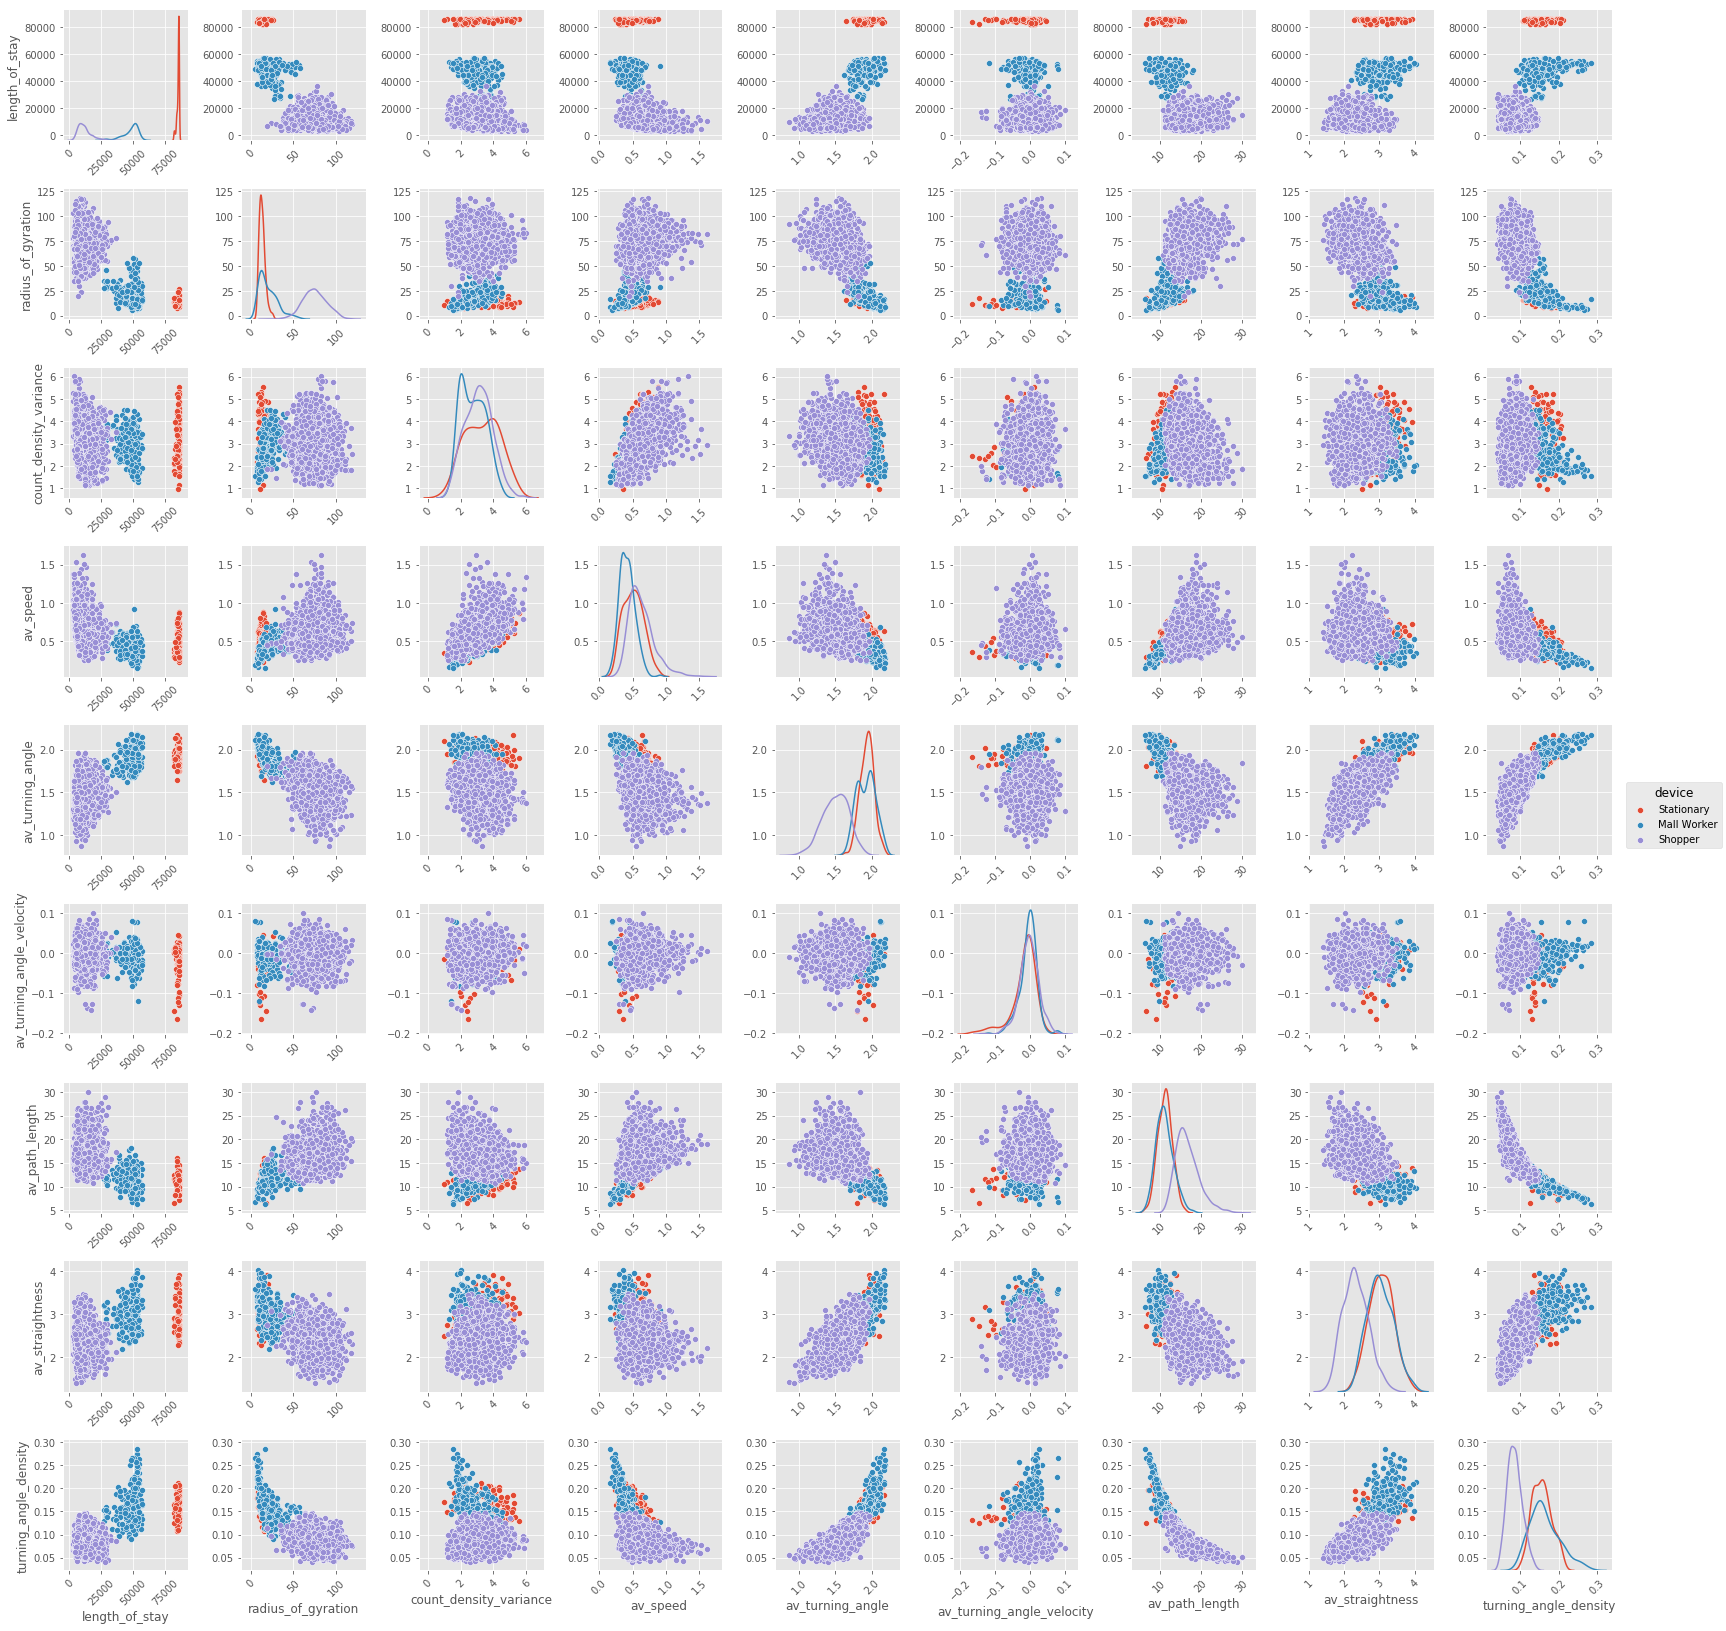

In [21]:
g = sns.pairplot(
    mac_address_classified_df.iloc[:2000],
    vars=FEATURE_LIST,
    hue="device", diag_kind="kde", dropna=True
)
 
for ax in g.axes.flat: 
    plt.setp(ax.get_xticklabels(), rotation=45)

The distributions are plotted for the three clusters 

c:\users\tvb\envs\venv-msci\lib\site-packages\pandas\core\generic.py:3110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
c:\users\tvb\envs\venv-msci\lib\site-packages\pandas\core\generic.py:3110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


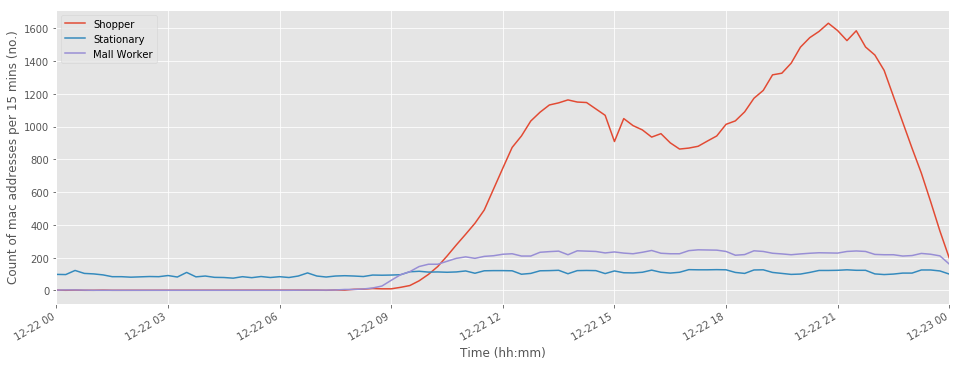

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 6))

macs = mac_address_classified_df[mac_address_classified_df.device == 'Shopper'].mac_address.tolist()

plot_histogram_jn(
    signal_df[signal_df.mac_address.isin(macs)], 
    axes=ax,
    label='Shopper',
);

macs = mac_address_classified_df[mac_address_classified_df.device == 'Stationary'].mac_address.tolist()

plot_histogram_jn(
    signal_df[signal_df.mac_address.isin(macs)], 
    axes=ax,
    label='Stationary',
);

macs = mac_address_classified_df[mac_address_classified_df.device == 'Mall Worker'].mac_address.tolist()

plot_histogram_jn(
    signal_df[signal_df.mac_address.isin(macs)], 
    axes=ax,
    label='Mall Worker',
);

The graphs above shows the number of devices that were seen in the mall over 15 minute intervals. The number of *Stationary devices* stays constant which is expected. The number of *Mall Workers* increases before the opening hours then stays constant until close. The number of *Shoppers* increases after the shops are open; there are two peaks around 13:30 and 21:00 **which are known to be the most busy times for the mall around Christmas (please check this)**.

### Get the dfa values

In [146]:
import warnings; warnings.filterwarnings("ignore")

mac_address_classified_df.loc[:, 'dfa'] = np.nan

stationary_workers_macs = mac_address_classified_df[
    (mac_address_classified_df.device == 'Stationary') |
    (mac_address_classified_df.device == 'Mall Worker')
].mac_address.tolist()

for mac in tqdm(stationary_workers_macs):
    dfa = nolds.dfa(
        signal_df[signal_df.mac_address == mac][['x', 'y']].as_matrix(),
    )
    mac_address_classified_df['dfa'][mac_address_classified_df.mac_address.isin([mac])] = dfa

HBox(children=(IntProgress(value=0, max=407), HTML(value='')))

AssertionError: 

## Distribution of points for stationary and mall workers (confirmation of difference)

Two plots are shown below for the stationary devices e.g. an ipad computer that has wifi in the store and mall workesr. The plots are scatters distributions of all the devices where the colour depict the denisty of the points. The yellow regions have a higher density of points and, therefore, are more likely to be where the device is located. The blue points are low density regions and are more likely to be the noice of the device.

### Distribution of stationary devices

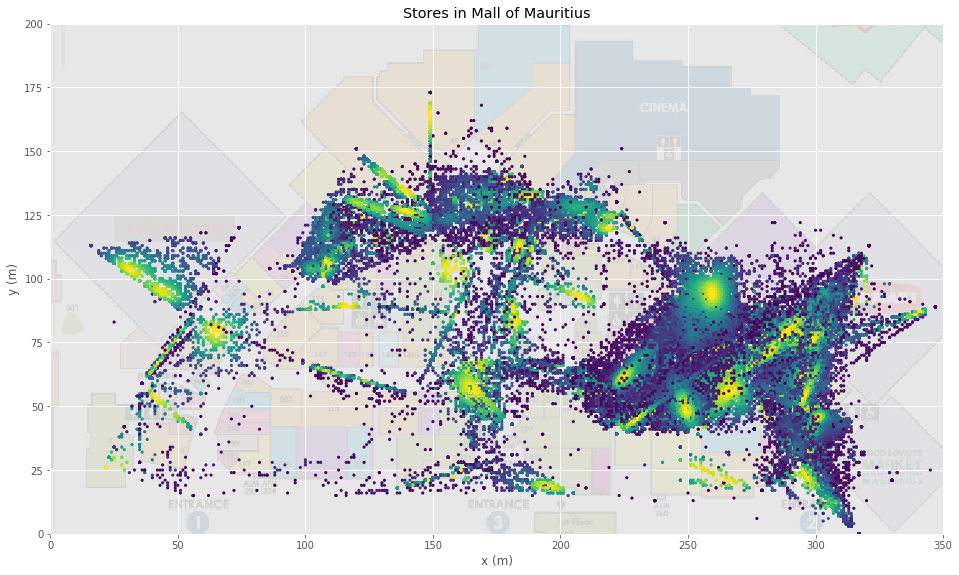

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 10))

plot_path_jn(
    signal_df, 
    mac_address_classified_df[mac_address_classified_df.device == 'Stationary'].mac_address.tolist(),
    axes=ax, 
    plot_type='density', 
    label=False
)

In [29]:
mac_address_classified_df.centroid.str[1:-1].str.split().str[0].astype(float).describe()

count    6727.000000
mean      185.147750
std        47.161353
min        31.161017
25%       155.164141
50%       181.352941
75%       213.738624
max       330.569024
Name: centroid, dtype: float64

In [68]:
mac_address_classified_df['x'] = mac_address_classified_df.centroid.str[1:-1].str.split().str[0].astype(float)
mac_address_classified_df['y'] = mac_address_classified_df.centroid.str[1:-1].str.split().str[1].astype(float)

c:\users\tvb\envs\venv-msci\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
c:\users\tvb\envs\venv-msci\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [1]:
test = mac_address_classified_df[mac_address_classified_df.device == 'Stationary']
test.loc[:, 'uncertainty_label'] = np.nan

NameError: name 'mac_address_classified_df' is not defined

In [110]:
samples = test.as_matrix(
    columns=['x', 'y', 'radius_of_gyration']
)
samples = scale(samples)

In [111]:
len(samples)

130

In [112]:
db = DBSCAN(eps=0.55, min_samples=6)
db.fit(samples)
labels = db.labels_

In [113]:
test['uncertainty_label'] = labels

c:\users\tvb\envs\venv-msci\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [114]:
test.uncertainty_label.value_counts()

 0    53
-1    52
 1    12
 3     9
 2     4
Name: uncertainty_label, dtype: int64

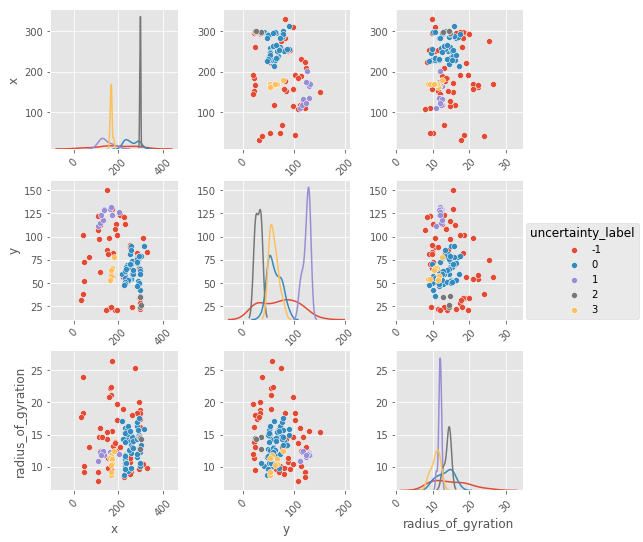

In [115]:
g = sns.pairplot(
    test,
    vars=['x', 'y', 'radius_of_gyration'],
    hue="uncertainty_label", diag_kind="kde", dropna=True
)
 
for ax in g.axes.flat: 
    plt.setp(ax.get_xticklabels(), rotation=45)

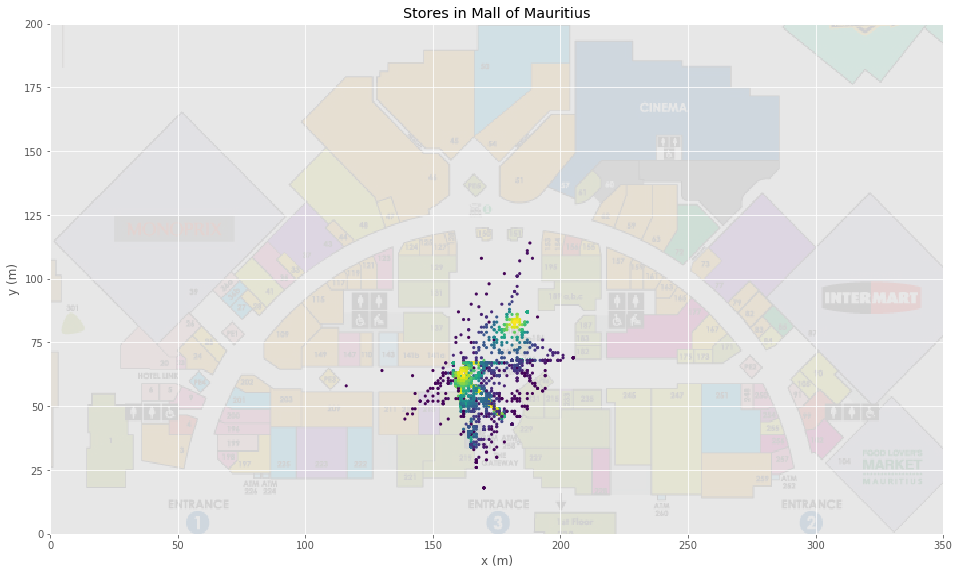

In [116]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 10))

plot_path_jn(
    signal_df, 
    test[test.uncertainty_label == 3].mac_address.tolist(),
    axes=ax, 
    plot_type='density', 
    label=False
)

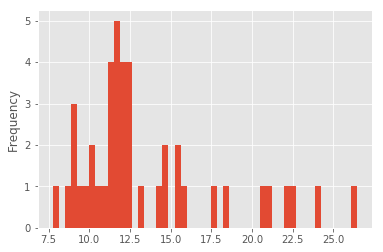

In [31]:
mac_address_classified_df[
    (mac_address_classified_df.device == 'Stationary') &
    (mac_address_classified_df.x < 175) 
].radius_of_gyration.plot.hist(bins=50)

In [43]:
mac_address_classified_df[
    (mac_address_classified_df.device == 'Stationary') &
    (mac_address_classified_df.x < 175) 
].radius_of_gyration.describe()

count    43.000000
mean     13.562138
std       4.446258
min       7.754455
25%      11.068296
50%      12.001772
75%      14.989867
max      26.465519
Name: radius_of_gyration, dtype: float64

In [58]:
stationary_x_large = mac_address_classified_df[
    (mac_address_classified_df.device == 'Stationary') &
    (mac_address_classified_df.x > 175)
].mac_address.tolist()

In [67]:
signal_df[signal_df.mac_address.isin([stationary_x_large[10]])].x.describe()

count    2067.000000
mean      255.778907
std         7.979522
min       219.000000
25%       251.000000
50%       255.000000
75%       262.000000
max       274.000000
Name: x, dtype: float64

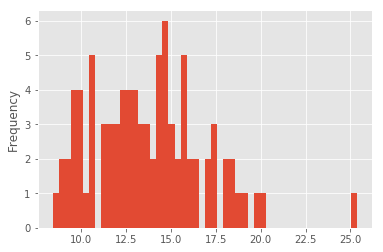

In [33]:
mac_address_classified_df[
    (mac_address_classified_df.device == 'Stationary') &
    (mac_address_classifietesttestd_df.x > 175) 
].radius_of_gyration.

In [42]:
mac_address_classified_df[
    (mac_address_classified_df.device == 'Stationary') &
    (mac_address_classified_df.x > 175) 
].radius_of_gyration.describe()

count    87.000000
mean     13.719726
std       3.085336
min       8.408424
25%      11.445636
50%      13.693609
75%      15.605156
max      25.377157
Name: radius_of_gyration, dtype: float64

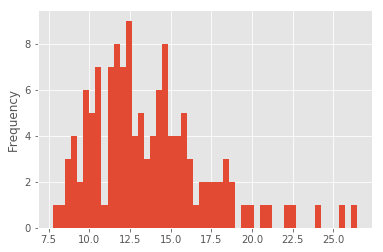

In [35]:
mac_address_classified_df[
    (mac_address_classified_df.device == 'Stationary')
].radius_of_gyration.plot.hist(bins=50)

## Animation

In [ ]:
from IPython.display import HTML
plt.rcParams['animation.ffmpeg_path'] = 'C:\\ffmpeg\\bin\\ffmpeg.exe'

In [ ]:
%%capture

anim = animate(
    signal_df, 
    mac_address_classified_df[
        (mac_address_classified_df.device == 'Mall Worker') &
        (mac_address_classified_df.dfa < 0.1) & 
        (mac_address_classified_df.dfa.notnull())
    ].mac_address.tolist()[25],
    jn=True
)

In [ ]:
HTML(anim.to_html5_video())